In [8]:
import os
import pandas as pd

In [9]:

dataset_name = 'Synthetic'

# should not be modified
value_relation = '/m/is_a'
category_a = '/m/high'
category_b = '/m/low'

In [10]:
# read the true literal values that are used to classify into the two categories (the file should only contain one literal relation type)
df_literals = pd.read_csv(f'data/{dataset_name}/literals/numerical_literals.txt', sep='\t', header=None,  names=["head", "relation", "literal"])

In [11]:
# derive human entities from the class mapping file
class_mapping_df = pd.read_csv('FB15k-237_class_mapping.csv', sep=';', header=0)
human_uris = class_mapping_df[class_mapping_df["class_label"] == "human"]["dataset_entity"]

In [12]:
df_literals[df_literals['head'].isin(human_uris.to_list())]

,head,relation,literal
3,/m/01sl1q,/m/has_value,0.284997
6,/m/07nznf,/m/has_value,0.414713
8,/m/0q9kd,/m/has_value,0.379819
15,/m/04bdxl,/m/has_value,0.303381
17,/m/079vf,/m/has_value,0.983388
...,...,...,...
13503,/m/09f5pp,/m/has_value,0.790471
13647,/m/0glyyw,/m/has_value,0.686262
13704,/m/06rkl,/m/has_value,0.418615
13717,/m/02p59ry,/m/has_value,0.224405


In [13]:
def get_scores_for_certain_tail(tail_entity, df_results):
    related_scores = pd.merge(df_literals[df_literals['head'].isin(human_uris.to_list())], df_results[df_results["tail"]==tail_entity][['head', 'score']], left_on='head', right_on='head')
    related_scores = related_scores.rename(columns={ 'score': f'score {tail_entity}' })
    return related_scores

In [29]:
NUM_RUNS = 3

out_file = open('data/tex/synthetic_tab.tex', 'w')


run_name_2_model_name = {
    'ranks_test_evaluation_DistMult_0.2_0.0_literal': 'LiteralE$_{DistMult}$',
    'ranks_test_evaluation_ComplEx_0.2_0.0_literal': 'LiteralE$_{ComplEx}$',
    'ranks_test_evaluation_KBLN_0.2_0.0_literal': 'KBLN',
    'ranks_test_evaluation_MTKGNN_0.2_0.0_literal': 'MTKGNN',
    'ranks_test_evaluation_TransEA_0.3': 'TransEA'
}

head = """
\\begin{table}[]

\setlength{\\tabcolsep}{6pt}
\\renewcommand{\\arraystretch}{1.1}

\caption{Scores achieved on the synthetic dataset.}
\\begin{center}

\\begin{tabular}{l|lr|lr}
\hline
& \multicolumn{2}{c|}{\\textbf{original}}                            & \multicolumn{2}{c}{\\textbf{random}}                              \\\\
& \multicolumn{1}{c}{\\textbf{ACC}} & \multicolumn{1}{c|}{\\textbf{Rank} $_{diff}$} & \multicolumn{1}{c}{\\textbf{ACC}} & \multicolumn{1}{c}{\\textbf{Rank} $_{diff}$} \\\\ \hline
"""

tail = """
\hline
\end{tabular}

\end{center}
\end{table}
"""


out_file.write(head)

for run_name in ['ranks_test_evaluation_DistMult_0.2_0.0_literal', 'ranks_test_evaluation_ComplEx_0.2_0.0_literal', 'ranks_test_evaluation_KBLN_0.2_0.0_literal', 'ranks_test_evaluation_MTKGNN_0.2_0.0_literal', 'ranks_test_evaluation_TransEA_0.3']:

    line_string = f'{run_name_2_model_name[run_name]}'

    for literal_type in ['numerical_literals', 'rand']:

        acc_scores = []
        mr_diff_scores = []

        for i in range(1, NUM_RUNS + 1):
            result_file = f'data/saved_models/saved_models_run_{i}/{run_name}_Synthetic_{literal_type}_train.tsv'

            if not os.path.exists(result_file):
                print(f'Run {i} does not exist')
            else:
                df_results = pd.read_csv(result_file, sep='\t', header=None,  names=["head", "relation", "tail", "rank head", "rank tail", "score"])
                # read the results (only value_relation triples are relevant for the evaluation, therefore we filter the dataframe)
                df_results = df_results[df_results['relation']==value_relation]

                # acc score
                a = get_scores_for_certain_tail(category_a, df_results)
                b = get_scores_for_certain_tail(category_b, df_results)
                merged = pd.merge(a, b)

                if len(merged) == 0:
                    print(f'No results for {result_file}')
                    continue

                acc = (len(merged[merged['literal'] > 0.5][merged[f'score {category_a}'] > merged[f'score {category_b}']]) + len(merged[merged['literal'] <= 0.5][merged[f'score {category_a}'] < merged[f'score {category_b}']])) / len(merged)
                acc_scores.append(acc)

                # MR diff
                # filter dataframes to only contain the relevant entities
                no_human_results = df_results[~df_results['head'].isin(human_uris.to_list())]
                human_results = df_results[df_results['head'].isin(human_uris.to_list())]

                # compute MR for human and non-human entities
                mr_no_human = no_human_results[no_human_results['relation']==value_relation]['rank tail'].mean()
                mr_human = human_results[human_results['relation']==value_relation]['rank tail'].mean()

                mr_diff = mr_no_human - mr_human
                mr_diff_scores.append(mr_diff)

        acc_scores_mean, acc_scores_std = round(pd.Series(acc_scores).mean(), 3), round(pd.Series(acc_scores).std(), 3)
        mr_diff_scores_mean, mr_diff_scores_std = round(pd.Series(mr_diff_scores).mean(), 3), round(pd.Series(mr_diff_scores).std(), 3)

        line_string += f' & ${acc_scores_mean:.3f} {{\scriptstyle \pm {acc_scores_std:.3f}}}$ & ${mr_diff_scores_mean:.3f} \pm {{\scriptstyle \pm {mr_diff_scores_std:.3f}}}$'

    out_file.write(line_string + '\\\\ \n')

out_file.write(tail)
out_file.close()

Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
Run 2 does not exist
Run 3 does not exist
No results for data/saved_models/saved_models_run_1/ranks_test_evaluation_TransEA_0.3_Synthetic_numerical_literals_train.tsv
Run 2 does not exist
Run 3 does not exist
No results for data/saved_models/saved_models_run_1/ranks_test_evaluation_TransEA_0.3_Synthetic_rand_train.tsv
Run 2 does not exist
Run 3 does not exist


/var/folders/vc/8d10xrmj0xj3v8g5_6zpmmkm0000gn/T/ipykernel_12911/1236818599.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  acc = (len(merged[merged['literal'] > 0.5][merged[f'score {category_a}'] > merged[f'score {category_b}']]) + len(merged[merged['literal'] <= 0.5][merged[f'score {category_a}'] < merged[f'score {category_b}']])) / len(merged)
/var/folders/vc/8d10xrmj0xj3v8g5_6zpmmkm0000gn/T/ipykernel_12911/1236818599.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  acc = (len(merged[merged['literal'] > 0.5][merged[f'score {category_a}'] > merged[f'score {category_b}']]) + len(merged[merged['literal'] <= 0.5][merged[f'score {category_a}'] < merged[f'score {category_b}']])) / len(merged)
/var/folders/vc/8d10xrmj0xj3v8g5_6zpmmkm0000gn/T/ipykernel_12911/1236818599.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  acc = (len(merged[merged['literal'] > 0.5][merged[f'score {category

todo: update formular
$MR_{diff} = \frac{\sum_{(s,p,o) \in G_{\neg human}}  r(s,p,o)    }{ |G_{\neg human}|}      -        \frac{\sum_{(s,p,o) \in G_{human}}  r(s,p,o)    }{ |G_{human}|}  $

In [25]:
prediction = []
for high, low in zip(merged['score /m/high'], merged['score /m/low']):
    if high > low:
        prediction.append(1)
    else:
        prediction.append(0)

In [26]:
merged['literal']

0      0.983388
1      0.052213
2      0.221566
3      0.565050
4      0.711868
         ...   
670    0.736635
671    0.214328
672    0.358785
673    0.285680
674    0.790471
Name: literal, Length: 675, dtype: float64

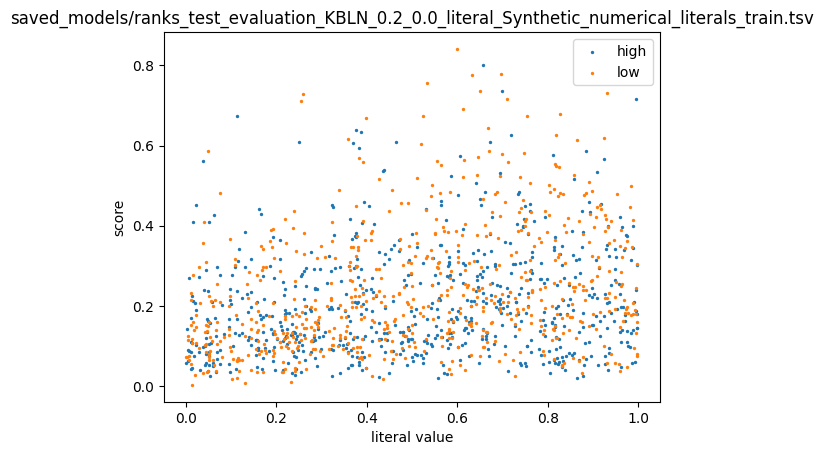

In [35]:
import matplotlib.pyplot as plt

plt.scatter(merged['literal'], merged['score /m/high'], s=2)
plt.scatter(merged['literal'], merged['score /m/low'], s=2)

plt.xlabel('literal value')
plt.ylabel('score')
plt.title(result_file)
plt.legend(['high', 'low'])